### Pipeline for a single spikeglx session
- Load an exctractor for visualization of the data
- Get the motifs
- Sync the nidaq/ap channels
- Sort it using kilosort and save the sorts
- Load the sort
- View rasters

In [1]:
%matplotlib inline

import os
import glob
import logging
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
from ceciestunepipe.file import filestructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-06-24 18:01:52,449 root         INFO     all modules loaded


In [4]:
se.__version__

'0.9.6'

In [5]:
si.__version__

'0.12.0'

### Session parameters and raw files

##### list the sessions for a bird

In [96]:
reload(et)


bird = 'z_w12m7_20'
all_bird_sess = et.list_sessions(bird)
all_bird_sess

['20201105', '20201106', '20201104']

##### set session parameters for the experiment structure (bird, session, probe, sort instance)

In [97]:
sess_par = {'bird': 'z_w12m7_20',
           'sess': '20201104',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2 # vrsion of sort (many sorts could have been performed/curated using different parameters)
           }

# get the folder structure for the experiment
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])
ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [98]:
sess_epochs = sglu.list_sgl_epochs(sess_par)
sess_epochs

2021-05-28 14:29:58,136 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.

['20201104_alles',
 '2500r250a_3500_dir_g0',
 '2500r250a_3500_dir_g1',
 '2500r250a_3500_dir_g2']

In [99]:
### pick a session
reload(et)
reload(sglu)
epoch = sess_epochs[1] # g2 is the shortest

exp_struct = sglu.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['raw'])

In [100]:
sgl_folders

{'nidq': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0',
 'imec_0': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0'}

In [101]:
sgl_files

{'nidq': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0/2500r250a_3500_dir_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0/2500r250a_3500_dir_g0_t0.imec0.ap.meta']}

In [102]:
files_pd = pd.DataFrame(sgl_files)

In [103]:
files_pd

nidq  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                lf_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                ap_0  
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...

In [104]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


In [108]:
pwd


'/mnt/cube/earneodo/repos/ceciestunepipe'

In [110]:
run_recordings
import pickle
with open('/mnt/cube/earneodo/run_recordings.pkl', 'wb') as handle:
    pickle.dump(run_recordings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/mnt/cube/earneodo/run_recordings.pkl', 'rb') as handle:
    b = pickle.load(handle)
    
b

MemoryError: 

### view the nidaq data

In [19]:
run_recordings['nidq']

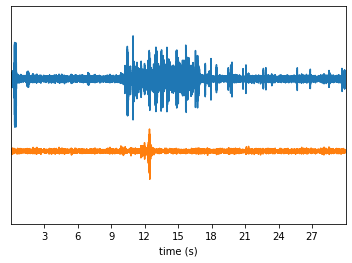

In [20]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 7], trange=[0,30])

In [21]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

2021-05-27 16:44:21,918 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 16:44:21,918 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [22]:
run_recordings['lf_0']._raw.shape

(385, 19105464)

In [23]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

32.00272005955993

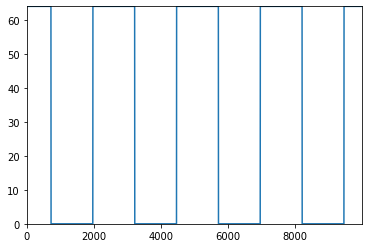

In [24]:
plt.plot(syn_ch_arr[:10000])

In [25]:
run_recordings['ap_0']._meta

{'acqApLfSy': '384,384,1',
 'appVersion': '20200520',
 'fileCreateTime': '2020-11-04T15:20:35',
 'fileName': 'D:/experiment/raw_data/z_w12m7_20/20201104/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0/2500r250a_3500_dir_g0_t0.imec0.ap.bin',
 'fileSHA1': '183D71F17699AF554A3FAB3769CB8984E8971F87',
 'fileSizeBytes': '176534483510',
 'fileTimeSecs': '7642.1937819205605',
 'firstSample': '2543189',
 'gateMode': 'Immediate',
 'imAiRangeMax': '0.6',
 'imAiRangeMin': '-0.6',
 'imCalibrated': 'true',
 'imDatApi': '1.20',
 'imDatBs_fw': '1.1.123',
 'imDatBsc_fw': '1.0.151',
 'imDatBsc_hw': '5.1',
 'imDatBsc_pn': 'NP2_HS_30',
 'imDatBsc_sn': '567',
 'imDatFx_hw': '1.2',
 'imDatFx_pn': 'NP2_FLEX_0',
 'imDatHs_fw': '5.2',
 'imDatHs_pn': 'NP2_HS_30',
 'imDatHs_sn': '1807',
 'imDatPrb_pn': 'PRB_1_4_0480_1',
 'imDatPrb_port': '4',
 'imDatPrb_slot': '2',
 'imDatPrb_sn': '19108322052',
 'imDatPrb_type': '0',
 'imLEDEnable': 'false',
 'imMaxInt': '512',
 'imRoFile': 'D:/experiment/raw_data/audio_test/

In [27]:
from scipy.io import wavfile
from scipy import signal

In [32]:
read_exp_base = os.environ.get('EXPERIMENT_PATH')
print(read_exp_base)
location_dict = get_locations_from_hostname()
location_dict

None


NameError: name 'get_locations_from_hostname' is not defined

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

2021-05-27 16:53:43,229 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 16:53:43,229 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


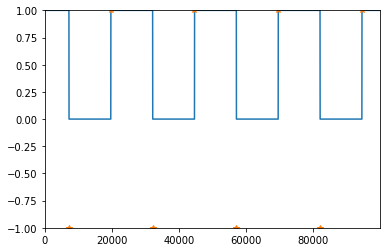

In [33]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

In [34]:
nidq_syn_ttl

(array([ 7198, 19698, 32197, 44697, 57197, 69697, 82197, 94697]),
 array([-1,  1, -1,  1, -1,  1, -1,  1]))

2021-05-27 16:53:44,330 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 16:53:44,330 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 16:53:44,332 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (100000,)
2021-05-27 16:53:44,332 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (100000,)
2021-05-27 16:53:45,004 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 34.33152
2021-05-27 16:53:45,004 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 34.33152
2021-05-27 16:53:45,007 ceciestunepipe.util.spikeext

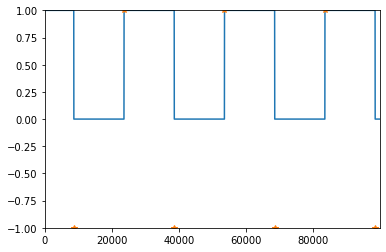

In [35]:
### the digital chan and the syn extraction of the nidq rec
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 100000, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=100000)

plt.plot(ap_syn.flatten())
plt.plot(*ap_syn_ttl, '*')

In [36]:
exp_struct

{'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/2500r250a_3500_dir_g0',
  'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/2500r250a_3500_dir_g0',
  'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0',
  'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104/2500r250a_3500_dir_g0',
  'tmp': '/scratch/earneodo/tmp/tmp/2500r250a_3500_dir_g0',
  'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/2500r250a_3500_dir_g0',
  'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0'},
 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/params.json',
  'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf',
  'rig': '/mnt/cube

##### get the microphone channel

In [37]:
from ceciestunepipe.util.sound import spectral as sp
from scipy.io import wavfile

In [38]:
mic_chan_id = [0]

mic_stream = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id)

In [39]:
mic_stream.shape

(1, 191052384)

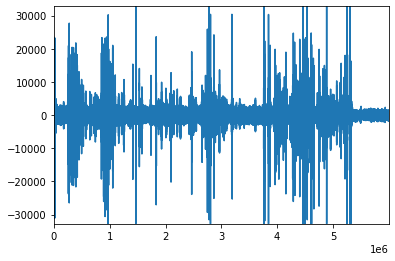

In [40]:
plt.plot(mic_stream[0, :6000000])

In [41]:
s_f = run_recordings['nidq'].get_effective_sf()[0]

In [42]:
run_recordings['nidq']._s_f_0

24999.666666666668

In [43]:
s_f

24999.666666666668

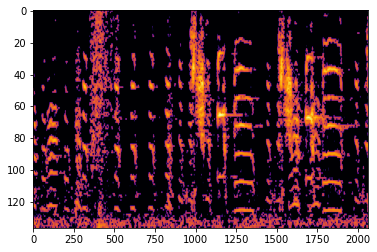

In [44]:
reload(sp)
f, t, s = sp.ms_spectrogram(mic_stream[0, 300000:350000], s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [45]:
mic_file_name = os.path.join(exp_struct['folders']['processed'], 'wav_mic.wav')
mic_file_name

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/wav_mic.wav'

In [46]:
from scipy.io import wavfile

In [47]:
def mic_to_wav(recording_extractor, mic_chan_list: list, wav_path:str):
    # get the stream
    mic_stream = recording_extractor.get_traces(channel_ids=mic_chan_list)
    # make sure folder exists
    logger.info('saving {}-shaped array as wav in {}'.format(mic_stream.shape, wav_path))
    os.makedirs(os.path.split(wav_path)[0], exist_ok=True)
    # write it
    s_f = int(round(recording_extractor.get_sampling_frequency()/1000))*1000
    logger.info('sampling rate {}'.format(s_f))
    wavfile.write(wav_path, s_f, mic_stream.T)
    
mic_to_wav(run_recordings['nidq'], mic_chan_id, mic_file_name)

2021-05-27 16:54:23,245 root         INFO     saving (1, 191052384)-shaped array as wav in /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/wav_mic.wav
2021-05-27 16:54:23,245 root         INFO     saving (1, 191052384)-shaped array as wav in /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/wav_mic.wav
2021-05-27 16:54:23,250 root         INFO     sampling rate 25000
2021-05-27 16:54:23,250 root         INFO     sampling rate 25000


#### match_template

In [48]:
s_f
n_window = 128

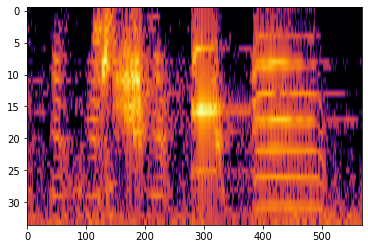

In [49]:
temp_start_sample = int(12.83 * s_f)
temp_end_sample = temp_start_sample + int(s_f*0.55)

template1 = mic_stream[0, temp_start_sample: temp_end_sample]

f, t, s1 = sp.ms_spectrogram(template1, s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s1[::-1]), aspect='auto', cmap='inferno')

In [50]:
s1.shape

(34, 568)

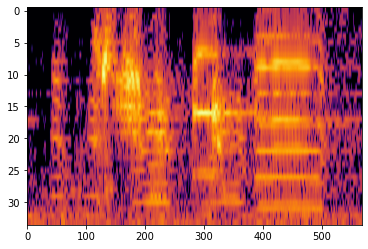

In [51]:
temp_start_sample = int(13.35 * s_f)
temp_end_sample = temp_start_sample + int(s_f*0.55)

template2 = mic_stream[0, temp_start_sample: temp_end_sample]

f, t, s2 = sp.ms_spectrogram(template2, s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s2[::-1]), aspect='auto', cmap='inferno')

In [52]:
plt.imshow(np.log(s_all[:, 10000:16000][::-1]), aspect='auto', cmap='inferno')

NameError: name 's_all' is not defined

In [54]:
def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

s_ref = spectral_diff(s1[:,15:], s1[:,:-15])
s_ref

0.00814353388205458

In [55]:
def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

spectral_diff(s1, s2)

rms_t = np.array([spectral_diff(s1, s_some[:, i: i+s1.shape[1]]) for i in range(s_some.shape[1] - s1.shape[1])])

NameError: name 's_some' is not defined

In [49]:
plt.plot(1 - rms_t)

NameError: name 'rms_t' is not defined

In [56]:
1 - spectral_diff(s1[:,15:], s1[:,:-15])

0.9918564661179454

In [57]:
spectral_diff(s1[:,15:], s1[:,:-15])

0.00814353388205458

In [58]:
# closest khz sampling frequency for ms step spectrogram
s_f_khz = int(round(run_recordings['nidq']._s_f_0 * 0.001)) * 1000
s_f_khz

25000

In [59]:
def match_template(x, template, s_f, f_min=300, f_max=7000, n_window=128, threshold=None):
    # get the spectrogram of all of the signal
    # get the differences along the time axis
    # find peaks
    # if threshold is none, compute a reference that is the self-similarity of the pattern when shifted 20 ms
    
    # compute the difference between the template and the spectrogram
    
    # very inefficient (and memory consuming)
    logger.info('Getting spectrogram of the whole mic channel')
    
    f, t_all, s_all = sp.ms_spectrogram(x, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    f, t_temp, s_temp = sp.ms_spectrogram(template, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    if threshold is None:
        logger.info('no threhold was entered, will set it from self-similarity of pattern shifted 20ms')
        threshold = spectral_diff(s_temp[:,15:], s_temp[:,:-15])
        logger.info('threshold is {}'.format(threshold))
    
    n_s = s_temp.shape[1]
    n_a = s_all.shape[1]
    
    logger.info('getting spectral differences')
    dist_t = np.array([spectral_diff(s_temp, 
                                     s_all[:, i: i + n_s]) for i in range(n_a - n_s)])
    
    # make positive to find peaks
    inv_dist_t = 1 - dist_t
    inv_thresh = 1 - threshold
    
    peaks = signal.find_peaks(inv_dist_t, height=inv_thresh, distance=int(n_s*0.7))
    
    return peaks, s_temp, s_all, dist_t


p, s_temp, s_all, dist_t = match_template(mic_stream.flatten(), template1, s_f_khz)


2021-05-27 16:55:26,952 root         INFO     Getting spectrogram of the whole mic channel
2021-05-27 16:55:26,952 root         INFO     Getting spectrogram of the whole mic channel
2021-05-27 16:55:49,878 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2021-05-27 16:55:49,878 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2021-05-27 16:55:49,884 root         INFO     threshold is 0.008391359816198728
2021-05-27 16:55:49,884 root         INFO     threshold is 0.008391359816198728
2021-05-27 16:55:49,885 root         INFO     getting spectral differences
2021-05-27 16:55:49,885 root         INFO     getting spectral differences


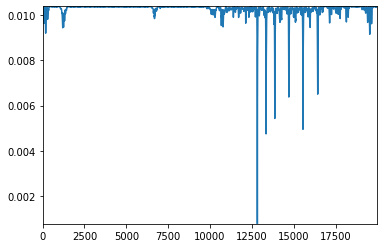

In [60]:
plt.plot(dist_t[:20000])

2021-05-27 17:15:16,430 root         INFO     plotting candidates
2021-05-27 17:15:16,430 root         INFO     plotting candidates
<ipython-input-61-3cb948f09b42>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


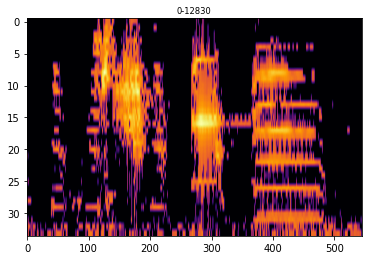

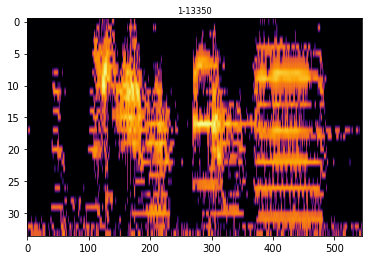

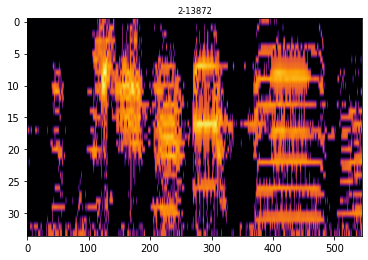

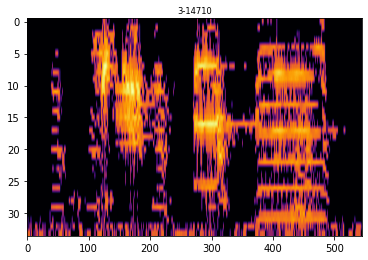

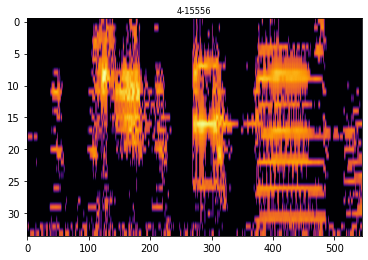

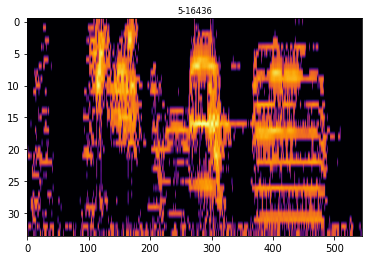

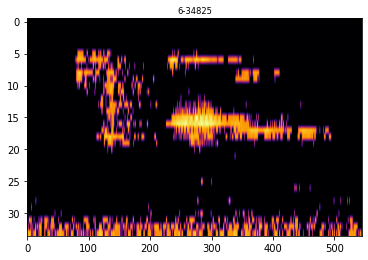

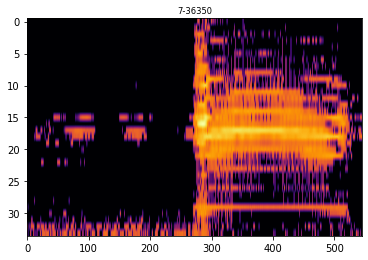

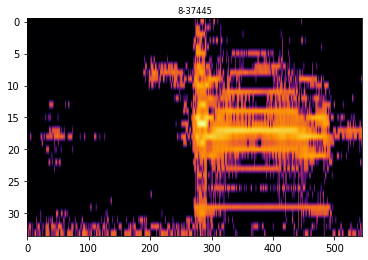

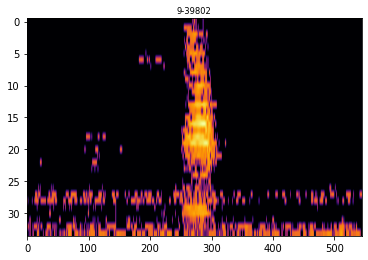

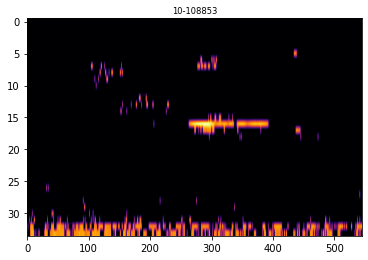

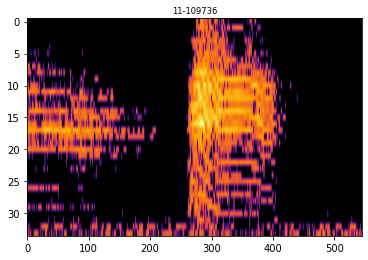

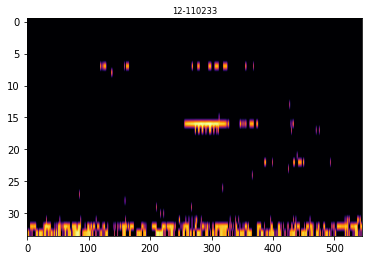

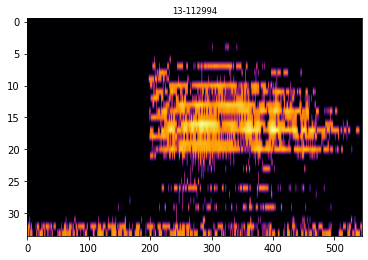

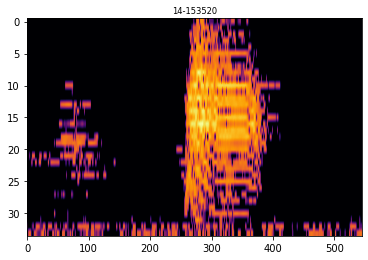

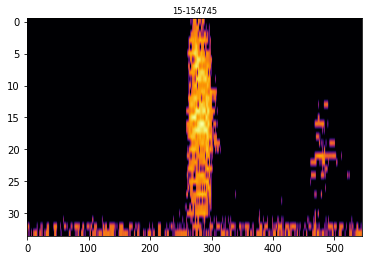

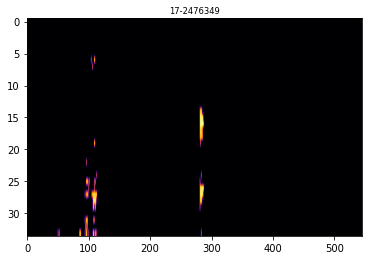

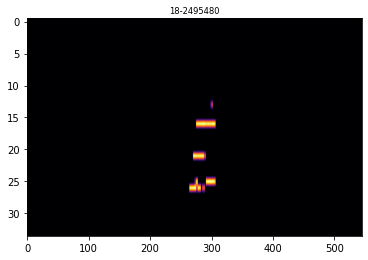

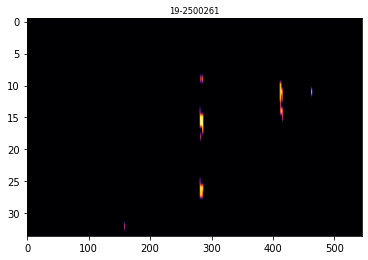

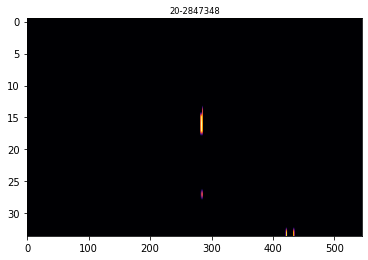

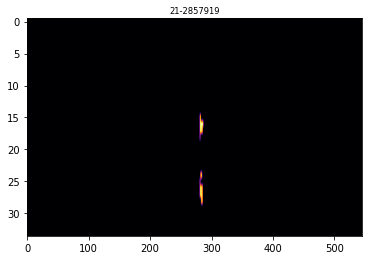

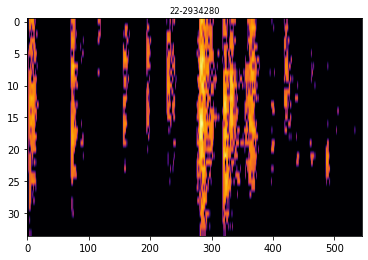

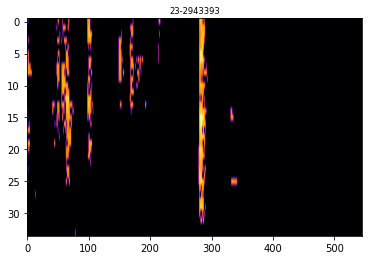

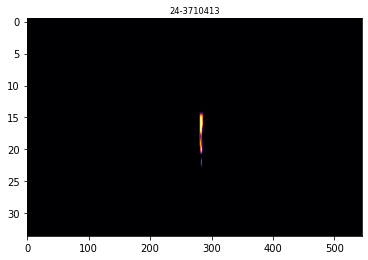

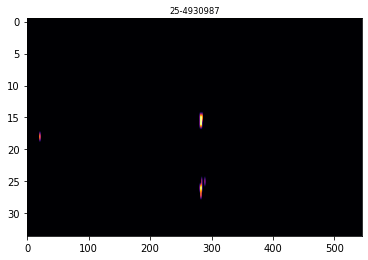

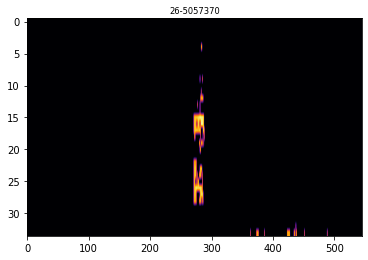

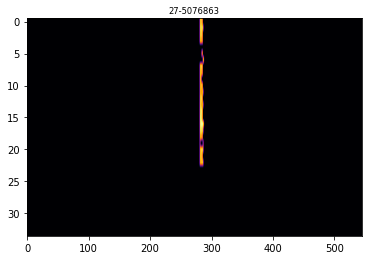

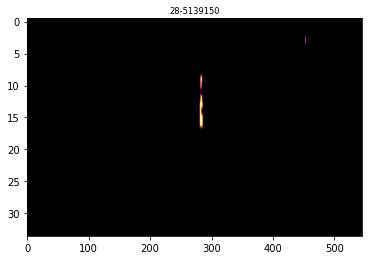

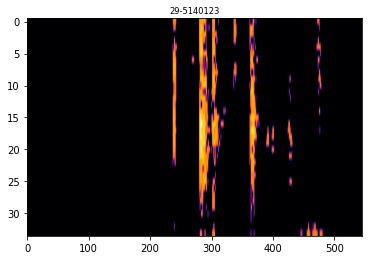

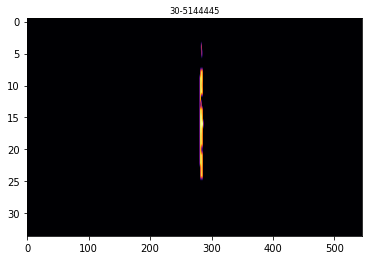

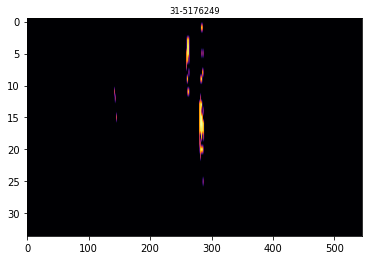

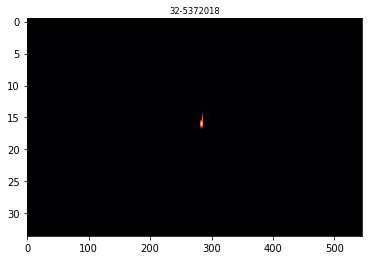

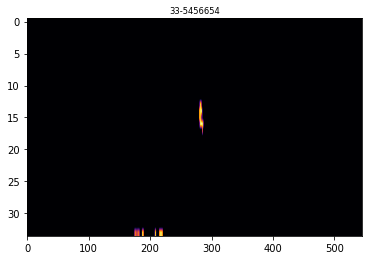

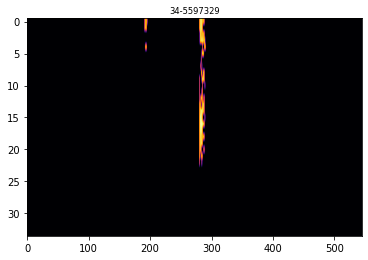

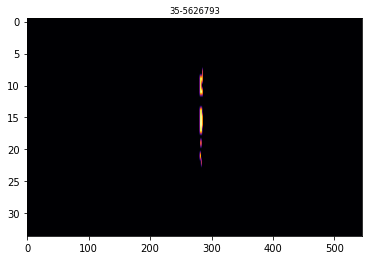

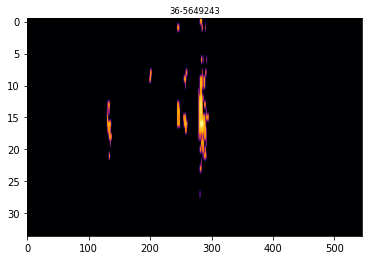

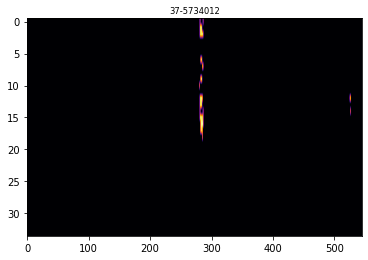

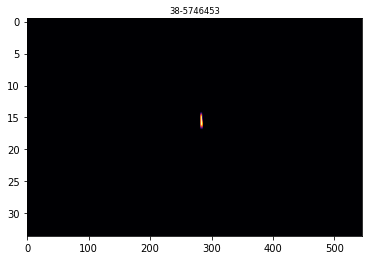

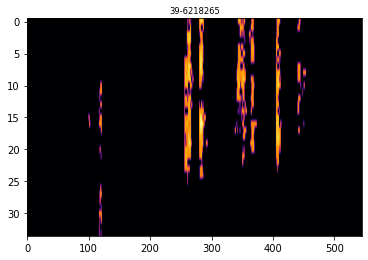

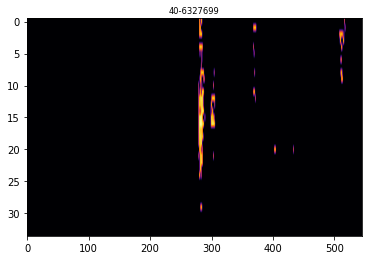

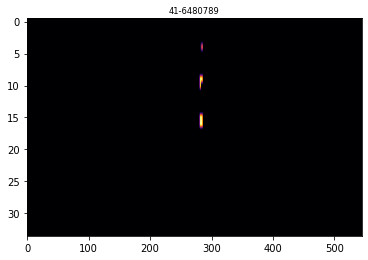

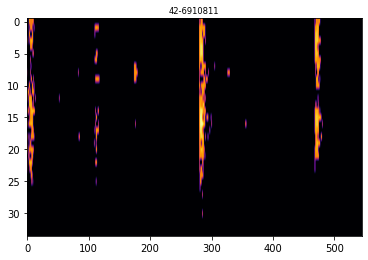

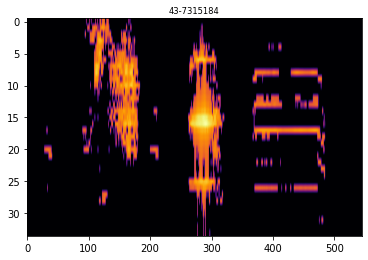

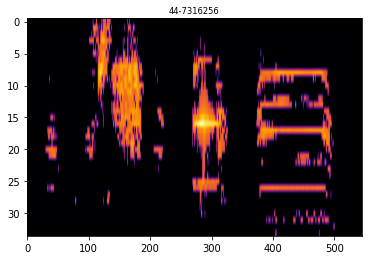

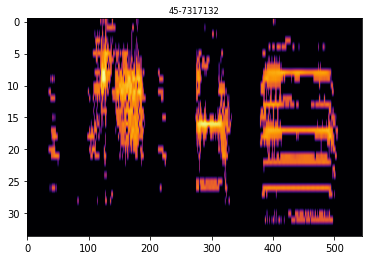

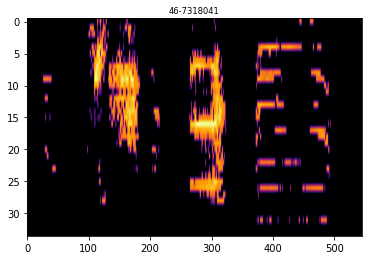

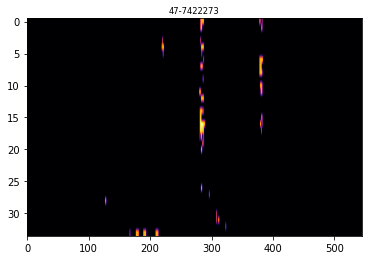

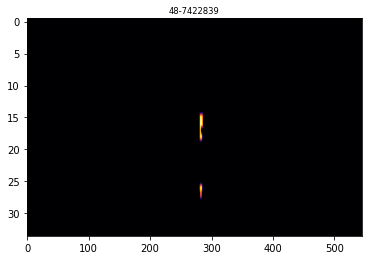

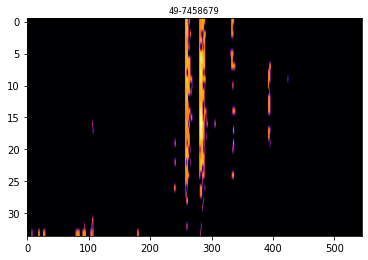

In [61]:
logger.info('plotting candidates')
for i, peak in enumerate(p[0]):
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))
    

##### Manually curate and confirm

In [62]:
curated_peaks = np.array([0, 1, 2, 3, 4, 5, 43, 44, 45, 46]).astype(np.int)
curated_peaks

array([ 0,  1,  2,  3,  4,  5, 43, 44, 45, 46])

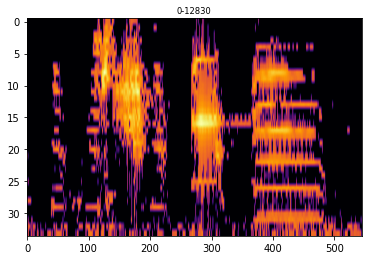

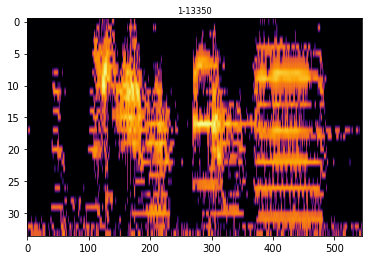

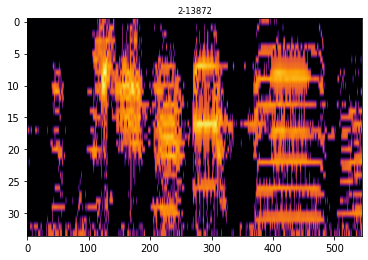

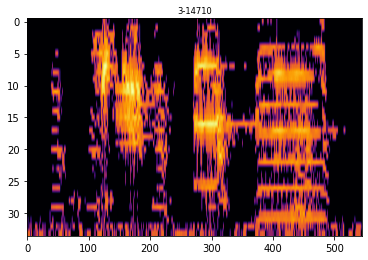

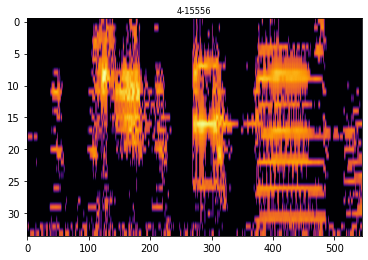

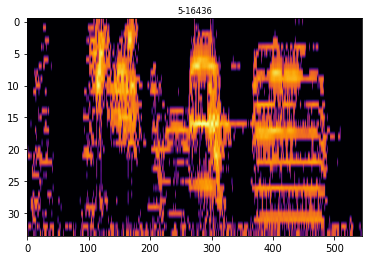

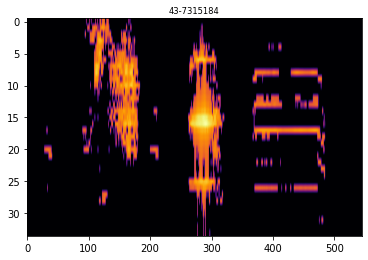

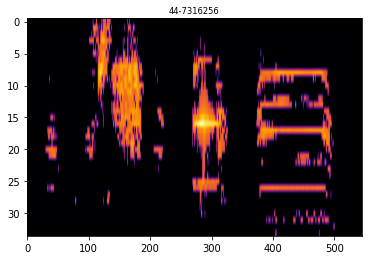

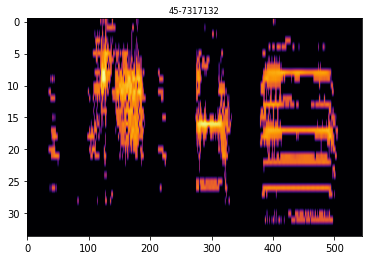

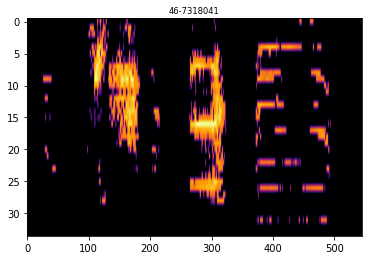

In [63]:
for i in curated_peaks:
    peak = p[0][i]
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

In [64]:
s_f

24999.666666666668

In [65]:
p[0][curated_peaks]


array([  12830,   13350,   13872,   14710,   15556,   16436, 7315184,
       7316256, 7317132, 7318041])

In [66]:
### make a dictionary
effective_sf = run_recordings['nidq'].get_effective_sf()[0]

# scale time linearly between the effective s_f and the khz_precise s_f used for the template matching
starts_ms = p[0][curated_peaks] * s_f_khz / effective_sf

mot_dict = {'template': template1,
            's_f': s_f_khz, # s_f used to get the spectrogram
           'start_ms': starts_ms,
           'start_sample_naive': (p[0][curated_peaks]  * s_f_khz * 0.001).astype(np.int),
           'start_sample_nidq': np.array([np.where(run_recordings['nidq']._t_0 > start)[0][0] for start in starts_ms*0.001]),
           }

mot_dict['start_t_0'] = run_recordings['nidq']._t_0[mot_dict['start_sample_nidq']]

t0_naive = run_recordings['nidq']._t_0[mot_dict['start_sample_naive']]

In [67]:
mot_dict

{'template': memmap([ 1650,  1551,   631, ..., -1943, -1825, -1245], dtype=int16),
 's_f': 25000,
 'start_ms': array([  12830.17106895,   13350.17800237,   13872.18496247,
          14710.19613595,   15556.2074161 ,   16436.21914959,
        7315281.53708716, 7316353.55138068, 7317229.56306084,
        7318138.575181  ]),
 'start_sample_naive': array([   320750,    333750,    346800,    367750,    388900,    410900,
        182879600, 182906400, 182928300, 182951025]),
 'start_sample_nidq': array([   320751,    333751,    346801,    367751,    388901,    410901,
        182879601, 182906401, 182928301, 182951026]),
 'start_t_0': array([  12.83021107,   13.350218  ,   13.87222496,   14.71023614,
          15.55624742,   16.43625915, 7315.28157709, 7316.35359138,
        7317.22960306, 7318.13861518])}

In [68]:
mot_dict['start_t_0']

array([  12.83021107,   13.350218  ,   13.87222496,   14.71023614,
         15.55624742,   16.43625915, 7315.28157709, 7316.35359138,
       7317.22960306, 7318.13861518])

In [69]:
mot_dict['start_sample_nidq']

array([   320751,    333751,    346801,    367751,    388901,    410901,
       182879601, 182906401, 182928301, 182951026])

In [70]:
mot_dict['start_sample_naive']

array([   320750,    333750,    346800,    367750,    388900,    410900,
       182879600, 182906400, 182928300, 182951025])

In [71]:
mic_stream.shape

(1, 191052384)

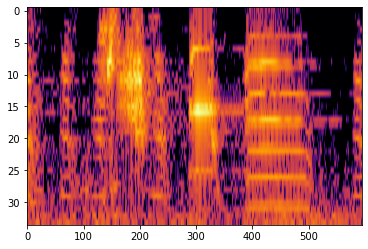

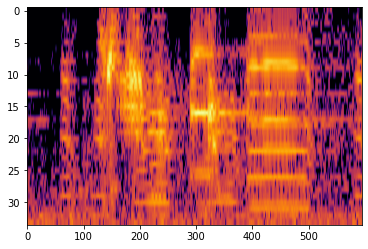

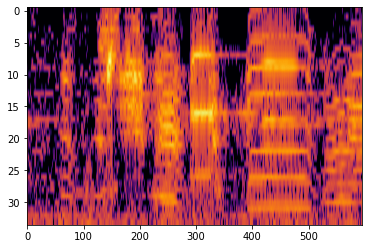

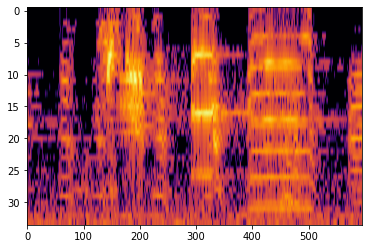

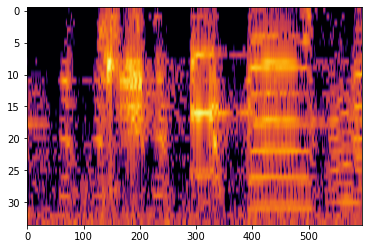

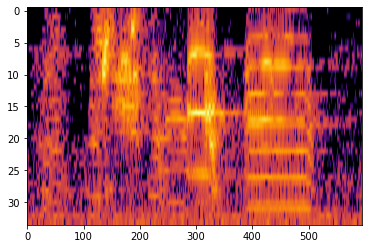

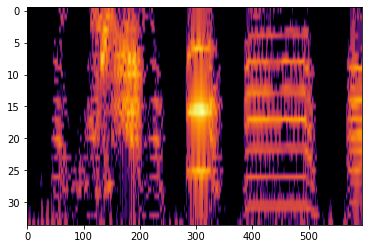

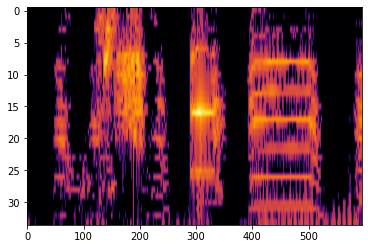

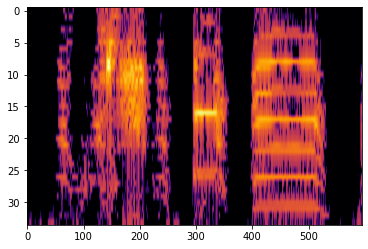

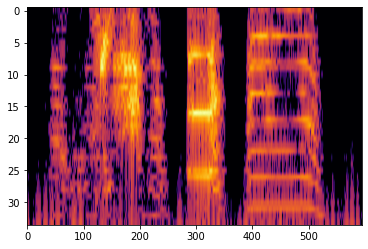

In [72]:
# plot one mot from the resampledtemp_start_sample = int(12.83 * s_f)
one_mic_stream = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id)[0]

for start_sample in mot_dict['start_sample_nidq']:
    
    temp_start_sample = start_sample - 512
    temp_end_sample = temp_start_sample + 15000

    mot_sample = one_mic_stream[temp_start_sample: temp_end_sample]

    f, t, s1 = sp.ms_spectrogram(mot_sample, s_f_khz, n_window)
    plt.figure()
    plt.imshow(np.log(s1[::-1]), aspect='auto', cmap='inferno')

In [73]:
curated_peaks

array([ 0,  1,  2,  3,  4,  5, 43, 44, 45, 46])

### The time syncronization

In [74]:
# t_0 is n/s_f (measured s_f)
# t_prime is interpolation to a t_ref (the nidaq, for instance, but it should be the one with the highest s_f)

In [75]:
def compute_sf(ttl: tuple) -> np.array:
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

np.mean(compute_sf(ap_syn_ttl))

30000.0

In [76]:
compute_sf(nidq_syn_ttl)

array([24999, 25000, 25000, 24999, 25000, 25000])

#### use the imec af as a pattern

In [77]:
signal = 'ap_0'

syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 120000, 0, [0], run_recordings[signal]._meta)

traces = run_recordings[signal].get_traces(end_frame=120000)
n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=120000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-05-27 17:15:29,358 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 17:15:29,358 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 17:15:29,360 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (120000,)
2021-05-27 17:15:29,360 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (120000,)
2021-05-27 17:15:29,368 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00213333333333
2021-05-27 17:15:29,368 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00213333333333
2021-05-27 17:15:29,371 ceciestune

In [78]:
ttl_edge_tuple_pattern = ttl_edge_tuple
s_f_pattern = s_f
t_pattern = t_0
t_pattern_edge = t_0_edge
syn_stream_pattern = syn_stream

In [79]:
#plt.plot(t_0_edge, np.ones_like(t_0_edge), '*')

In [80]:
s_f_pattern, t_pattern, ttl_edge_tuple_pattern = run_recordings[signal].get_effective_sf()

In [81]:
ttl_edge_tuple_pattern[0].shape

(8,)

#### fit the nidaq to the pattern

In [82]:
signal = 'nidq'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-05-27 17:15:30,194 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 17:15:30,194 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [83]:
run_recordings[signal].syn_to_pattern(t_pattern, ttl_edge_tuple_pattern)

array([6.58613333e-05, 1.05858667e-04, 1.45856000e-04, ...,
       7.64158607e+03, 7.64158611e+03, 7.64158615e+03])

### make the time conversions using the syn_to_sgl_rec_exctractor method

In [84]:
run_recordings['lf_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-05-27 17:15:35,429 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 17:15:35,429 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 17:15:35,430 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 17:15:35,430 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 17:15:35,431 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (229265563,)
2021-05-27 17:15:35,431 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn chann

In [85]:
run_recordings['nidq'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-05-27 17:31:18,248 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 17:31:18,248 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-27 17:31:18,251 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 17:31:18,251 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-27 17:31:18,252 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (229265563,)
2021-05-27 17:31:18,252 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn chann

KeyboardInterrupt: 

In [ ]:
run_recordings['ap_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

### plot the square syn signals in the three different timescales

In [ ]:
# sig = 'lf_0'
# t_start_plot = 125

# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'ap_0'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'nidq'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

### The sorting

In [ ]:
se.installed_recording_extractor_list

##### pick one ap stream, view it after running some of the toolkits

In [ ]:
ap_extractor = run_recordings['ap_0']

###### view it raw

In [ ]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[100,105])

###### filtered

In [ ]:
ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[100,105])

###### cmr

In [ ]:
ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(40, 50), trange=[100,105])

In [ ]:
exp_struct['folders']

In [ ]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [ ]:
def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort2',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=4096, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [ ]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [ ]:
default_ks2_params = ss.Kilosort2Sorter.default_params()
default_ks2_params

In [ ]:
1/100

##### manually enter ksort params

In [ ]:
ks2_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

In [ ]:
tmp_loc = exp_struct['folders']['ksort']
tmp_loc

In [ ]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle')

#sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

### load the sort

In [ ]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#sort_pickle_path

In [ ]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [ ]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [ ]:
reload(ks)

In [ ]:
!ls /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/tmp_ks2/

### plot a raster

In [ ]:
mot_dict

In [ ]:
# samples in nidq stream
# corresponding times in nidq stream tprime
nidq_samples = mot_dict['start_sample_nidq']
nidq_samples = mot_dict['start_sample_naive']

t_mot_prime = run_recordings['nidq']._t_prime[nidq_samples]

t_pre = -0.5
t_post = 1.5

t_range_arr = np.vstack([t_mot_prime + t_pre, t_mot_prime + t_post]).T

t_range_arr

In [ ]:
t0_naive

### Visualize a bout together with the neural traces

In [ ]:
t_start = t0_naive

In [ ]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [ ]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [ ]:
hvc_chans = list(range(290, 324)) #HVC
ra_chans = list(range(50, 101)) #RA

neur_chans = hvc_chans + ra_chans
# neur_chans = hvc_chans

mot_start_ms = 10076 # in nidq time
#mot_start_ms = 7619983

pre_sec = -2.25
post_sec = 8 - pre_sec

# get coincident starts in samples
# the nidq from the time, then convert that time to t_prime
nidq_start = np.where(run_recordings['nidq']._t_prime > mot_start_ms*0.001)[0][0]
t_prime_start = run_recordings['nidq']._t_prime[nidq_start]
nidq_sf = run_recordings['nidq']._s_f_0

# the ap sample from the t_prime
ap_start = np.where(run_recordings['ap_0']._t_0 > t_prime_start)[0][0]
ap_sf = run_recordings['ap_0']._s_f_0

mic_arr = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id, 
                                            start_frame=nidq_start + pre_sec*nidq_sf, 
                                            end_frame=nidq_start + post_sec*nidq_sf)


ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=ap_start + pre_sec*ap_sf, 
                                            end_frame=ap_start + post_sec*ap_sf)

In [ ]:
ap_start + pre_sec*ap_sf

In [ ]:
ap_sf

In [ ]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

In [ ]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks2'))
spk_df.head(1)

In [ ]:
## call the HVC/RA sites
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [ ]:
clu_df.head(1)

In [ ]:
plt.plot(clu_df.loc[0, 'main_wav_7']);

### get motif alinged rasters

In [ ]:
## use the starts in mot_dict start sample to get the t_prime
## get the samples for t_prime in the ap channel
## get those spikes

start_t_nidq = mot_dict['start_t_0']

mot_dict['start_t_ap_0'] = run_recordings['nidq']._t_prime[mot_dict['start_sample_nidq']]

mot_start_ap_samples = np.array([np.where(run_recordings['ap_0']._t_prime > start)[0][0] for start in mot_dict['start_t_ap_0']])

mot_dict['start_sample_ap_0'] = mot_start_ap_samples

In [ ]:
run_recordings['ap_0']._s_f_0

#### check alignment of the syn signals

In [ ]:
n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

In [ ]:
mot_dict

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [ ]:
mot_idx = 8
sec_before = 0
sec_after = 1

for mot_idx in range(9):
    start_ap = mot_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
    end_ap = mot_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

    start_nidq = mot_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
    end_nidq = mot_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(ap_syn[start_ap: end_ap], '-*')
    ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
    ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [ ]:
mot_dict['start_sample_ap_0'] + t_pre_samp

In [ ]:
mot_dict['start_sample_ap_0'] + t_post_samp

In [ ]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 0.5
t_post = 1.5

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)

#spk_arr = get_window_spikes(spk_df, clu_list, ap_samples[0] + t_pre_samp, ap_samples[0] + t_post_samp)


rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

In [ ]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])
plt.tight_layout()

In [ ]:
#### plot 50 rasters
fig, ax_arr = plt.subplots(nrows=20, figsize=[10, 15], sharex=True)

for i_rast, clu_idx in enumerate(range(20, 40)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])

In [ ]:
fig_path = os.path.join(exp_struct['folders']['processed'], 'rasters_0')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

In [ ]:
fig_path

In [ ]:
spk_arr.shape

In [ ]:
fig_path = os.path.join(exp_struct['folders']['processed'], 'bout_raster_1')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

In [ ]:
fig_path

In [ ]:
clu_df.head(1)

In [ ]:
clu_df.

In [ ]:
clu_nuclei = clu_df.loc[clu_df['cluster_id'].isin(clu_list), 'nucleus'].values
clu_nuclei

In [ ]:
ra_clu_idx = np.where(clu_nuclei=='ra')
hvc_clu_idx = np.where(clu_nuclei=='hvc')


In [ ]:
hvc_clu_idx

In [ ]:
clu_list

In [ ]:
reload(pu)

In [ ]:
# make 5ms bins and count spikes
bin_size_samples = 300

bin_spk_arr = pu.coarse(spk_arr.astype(np.float), bin_size_samples)
np.nan_to_num(bin_spk_arr, 0)

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(bin_spk_arr.T.astype(np.float), ax=ax[2])

### save cluster, motif and cluster metadata

In [ ]:
import pickle

In [ ]:
clu_df_path = os.path.join(exp_struct['folders']['processed'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['processed'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['processed'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(mot_dict, handle)


In [ ]:
exp_struct['folders']['processed']

In [ ]:
bin_spk_arr.shape

In [ ]:
from sklearn import decomposition 
# get the pca
pca_ra = decomposition.PCA(n_components=10)
pca_hvc = decomposition.PCA(n_components=10)

pc_ra = pca_ra.fit_transform(bin_spk_arr[ra_clu_idx[0][:24]].T)

pc_hvc = pca_hvc.fit_transform(bin_spk_arr[hvc_clu_idx[0][:24]].T)

In [ ]:
hvc_clu_idx[0]

In [ ]:
bin_spk_arr[ra_clu_idx[:40]].shape

In [ ]:
plt.plot(pc_hvc)

In [ ]:
plt.plot(pca_ra.explained_variance_ratio_.cumsum(), 'r*')
plt.plot(pca_hvc.explained_variance_ratio_.cumsum(), '*')

In [ ]:
pca_hvc.explained_variance_ratio_.cumsum()

In [ ]:
spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [1, 1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)


ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

ax[1].plot(pc_ra)
ax[2].plot(pc_hvc)


pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[3])



In [ ]:
pc_ra.shape

In [ ]:
plt.plot(*pc_ra[:,:].T, '-')

In [ ]:
plt.plot(*pc_hvc.T, '.-')

In [ ]:
### TODO
- NMF factorization
- color code the time
- look at it on a motif 
- shuffle each cell spike train inependently in time


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*pc_ra.T, '-.')

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*pc_hvc.T, '-.')

In [ ]:
spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[2])

In [ ]:
mua_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

spk_arr = get_window_spikes(spk_df, mua_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[2])

In [ ]:
spk_arr.shape

In [ ]:
clu_df.head(1)

In [ ]:
clu_df['KSLabel']

In [ ]:
clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])),:]

In [ ]:
clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])

In [ ]:
### get window spikes for ra/hvc during the bout
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 'cluster_id'])

#spk_arr = get_window_spikes(spk_df, clu_list, ap_samples[0] + t_pre_samp, ap_samples[0] + t_post_samp)

In [ ]:
clu_list

In [ ]:
t_pre_samp

In [ ]:
rast_arr.shape

In [ ]:
def coarse(x: np.ndarray, n_coarse: int):
    # coarse x along last dimension in bins of n_coarse size
    x_shape = x.shape
    last_dim = x.shape[-1]
    
    max_n = last_dim//n_coarse * n_coarse # chop it to the max integer coarse
    exploded_x = x[..., :max_n].reshape(*x_shape[:-1], -1, n_coarse)
    coarse_x = exploded_x.mean(axis=-1)
    return coarse_x

### get it in miliseconds
samples_in_ms = int(run_recordings['ap_0']._s_f_0 * 0.001)
samples_in_ms


clu_idx =  6 ##idx of the clu in the array
one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms//2)

one_raster_ms[one_raster_ms>0] = 1
one_raster_ms[one_raster_ms<0] = -1

plt.imshow((one_raster_ms[::-1]), aspect='auto', cmap='Greys')

In [ ]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='|', facecolor='k', rasterized=True)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

clu_idx = 105
ax = plot_as_raster(rast_arr[clu_idx].T, t_0=20000)

In [ ]:
#### plot 50 rasters
fig, ax_arr = plt.subplots(nrows=50, figsize=[7, 150], sharex=True)

for i_rast, clu_idx in enumerate(range(200, 250)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(rast_arr[clu_idx].T, t_0=20000, ax=ax_arr[i_rast])

In [ ]:
np.nansum(one_raster_ms)

In [ ]:
plt.plot(coarse(np.nansum(one_raster_ms, axis=0), 15))

In [ ]:
np.stack(spk_arr_list, axis=-1).shape

In [ ]:
plt.plot(rast_arr[clu_idx].sum(axis=1))

In [ ]:
rast_arr[clu_idx].shape

In [ ]:
one_raster_ms

In [ ]:
plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')

In [ ]:
spk_arr.shape

In [ ]:
clu_list

In [ ]:
loaded_sort.get_unit_property_names(5)

In [ ]:
loaded_sort.get_unit_property(5, 'KSLabel')

In [ ]:
loaded_sort.get_units_spike_train([5])

In [ ]:
loaded_sort.get_unit_property(5, 'KSLabel')

In [ ]:
u_wf = st.postprocessing.get_unit_waveforms(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

In [ ]:
u_wf[0].shape

In [ ]:
plt.plot(u_wf[1].mean(axis=0).T);

In [ ]:
u_wf = st.postprocessing.get_unit_max_channels(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

In [ ]:
all_unit_id = np.array(loaded_sort.get_unit_ids())

In [ ]:
loaded_sort.get_unit_property(5, 'pc_features')

In [ ]:
u_wf

In [ ]:
loaded_sort.get_shared_unit_spike_feature_names(unit_ids=[0,1])

In [ ]:
snrs = st.validation.compute_snrs(loaded_sort, ap_extractor)


In [ ]:
isi_violations = st.validation.compute_isi_violations(loaded_sort, 
                                                      duration_in_frames=ap_extractor.get_num_frames())

In [ ]:
wf = st.postprocessing.get_unit_waveforms(ap_extractor, loaded_sort, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [ ]:
wf[0].shape

In [ ]:
plt.plot(wf[13][:, 0, :].T);

In [ ]:
max_chan = st.postprocessing.get_unit_max_channels(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

In [ ]:
templates = st.postprocessing.get_unit_templates(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

In [ ]:
plt.plot(templates[0].T);

In [ ]:
np.where(np.array(max_chan)>0)

In [ ]:
loaded_sort.get_unit_property(15, 'max_channel')

### load the npy objects from kilosort

In [ ]:
spk_clu = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'spike_clusters.npy'))
spk_templates = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'templates.npy'))

In [ ]:
np.unique(spk_clu).shape

In [ ]:
spk_templates.shape

## Try with sglexp
make a pandas dataframe to keep track of epochs (folders), runs within each session, caryying the recording extractors

In [ ]:
from ceciestunepipe.util import sglxexp as sgle

In [ ]:
reload(sgle)
epoch_pd = sgle.make_sgl_epoch_dict(sess_par, sess_epochs[1])

In [ ]:
epoch_pd

In [ ]:
reload(sgle)
sess_pd = sgle.make_session_pd(sess_par)
sess_pd

### get some metadata

In [ ]:
def get_sess_pd_meta(sess_pd: pd.DataFrame) -> pd.DataFrame:
    # fields to pick from the sglx metadata
    sglx_fields = {}
    

### sort a merged recording extractor with all of the session epochs, runs

In [ ]:
def merge_pd(sess_pd: pd.DataFrame) -> pd.DataFrame:
    
    # get the list of existing recordings (one per stream)
    rec_list = [c for c in (sess_pd.columns) if 'rec' in c]
    
    # merge each column
    merged_rec_dict = {c: se.MultiRecordingTimeExtractor(recordings=list(sess_pd.loc[:, c].values)) for c in rec_list}
    
    merged_pd = pd.DataFrame.from_dict(merged_rec_dict, orient='index').T
    merged_pd['bird'] = sess_pd['bird']
    merged_pd['sess'] = sess_pd['sess']
    merged_pd['epoch'] = [list(sess_pd.loc[:, 'epoch'].values)]*len(merged_pd)
    merged_pd['run'] = [list(sess_pd.loc[:, 'run'].values)]*len(merged_pd)
    
    return merged_pd

reload(sgle)
merged_pd = sgle.merge_session_pd(sess_pd)

In [ ]:
merged_pd

In [ ]:
merged_pd.loc[0, 'rec-lf_0']

In [ ]:
merged_exp_struct = sglu.sgl_struct(sess_par, 'merge')
merged_exp_struct

In [198]:
tmp_loc

'/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2'

In [ ]:
sort_pickle_path = os.path.join(merged_exp_struct['folders']['ksort'], 'sort_ks2.pickle')
tmp_loc = merged_exp_struct['folders']['ksort']

sort = run_spikesort(merged_pd.loc[0, 'rec-ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-01-28 23:56:25,540 root         INFO     Grouping property: None
2021-01-28 23:56:25,542 root         INFO     sorting method: kilosort2
2021-01-28 23:56:25,543 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/tmp_ks2
2021-01-28 23:56:25,545 root         INFO     Will set visible gpu devices 1


In [80]:
sort